# Calibration: MST lowE ($E_c \in [1.6-6]$ keV)
### Patrick VanMeter
### January 2019

In [1]:
import os
import gc
import time
import cPickle as pickle
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import mesxr.calibration.trimscan as calib
import mesxr.calibration.plots as plot

%matplotlib inline

In [2]:
# Now let's attempt to identify the pixels with over-response at low trimbit and deal with them accordingly
def ratio_test(det, element, high=0, low=1):
    """
    A useful test to determine which pixels exhibit the outlier nonlinear response for low trimbits.
    """
    ratio_map = np.zeros(det.global_pixel_dims)
    
    for x in range(ratio_map.shape[0]):
        for y in range(ratio_map.shape[1]):
            if element in det.pixels[x,y].elements:
                elem_index = det.pixels[x,y].elements.index(element
                                                           )
                if high in det.pixels[x,y].trimbits[elem_index] and low in det.pixels[x,y].trimbits[elem_index]:
                    index_h = np.where(det.pixels[x,y].trimbits[elem_index] == high)[0][0]
                    index_l = np.where(det.pixels[x,y].trimbits[elem_index] == low)[0][0]
                    ratio_map[x,y] = det.pixels[x,y].data[elem_index][index_h] / (det.pixels[x,y].data[elem_index][index_l] + 0.001)
                    
                else:
                    ratio_map[x,y] = 0
            else:
                ratio_map[x,y] = 0
                    
    return ratio_map

First, let's do the actual calibration using my new calibration library. Then, the results will be examined and compared to the old method.

In [3]:
calib_base = '/home/pdvanmeter/data/meSXR/MST/trimscan_data/2017-06-22_2_to_7_keV_scan_vacuum'
elements = ['Zr', 'Mo', 'Ag', 'In', 'Ti', 'V']
trimscan_paths = [os.path.join(calib_base, 'calib_line={0:}_vrfp=0.050_vadj=1.160_vtrm=1.250_vcmp=0.800_trim=scan'.format(elem)) for elem in elements]
bad_pix = [(280, 55), (12, 71), (376, 94), (198, 117)]

load_calibration = True
save_path = '/home/pdvanmeter/data/meSXR/MST/calibration/pickles'
calibration_name = 'MST_lowE.pkl'

In [4]:
# The lowE calibration requires some additional constraints in order to get a good fit
# These were only detemined post-facto. Sometimes calibration must be an iterative process.
start_bit = np.zeros([len(elements), 16], dtype=int)
start_bit[:4, 2] = 4 # Set chip 2 to start at trimbit = 4 for low-energy lines
start_bit[4:, :] = 4 # For high-energy elements there is no need for the low-trimbit data on any chip

# Make the model here so that the Zr data can be removed for chip 2
if not load_calibration:
    p3_det = calib.Pilatus3_100k(elements, trimscan_paths, trimscan_paths[0], trimbit_start=start_bit, omit_trimbits=True)
    p3_det.modules[0,0].chips[2,0].remove_elements(['Zr'])

In [5]:
cutoff = 1.2
num_modified = 0

if not load_calibration:
    # Find the pixels
    ratios = ratio_test(p3_det, 'Ag')

    # Remove Zr from the data and set the start bit to 4 - exclude chip 2 since this has already been accounted for
    for x in range(ratios.shape[0]):
        for y in range(ratios.shape[1]):
            if ratios[x,y] > cutoff and p3_det.pixels[x,y].chip != 2 and p3_det.pixels[x,y].chip != -1:
                #print('Modifying ({0:d}, {1:d})'.format(x,y))
                p3_det.pixels[x,y].exclude_elements(['Zr'])
                p3_det.pixels[x,y].exclude_trimbits([0,1,2,3])
                num_modified += 1

In [6]:
print('Modified {0:d} pixels.'.format(num_modified))

Modified 3036 pixels.


In [7]:
start_t = time.time()

if not load_calibration:
    p3_det.calibrate(num_cores=16, bad_pix=bad_pix)
    
    # Save the resulting calibration for future use
    file = open(os.path.join(save_path, calibration_name), 'wb')
    gc.disable()
    pickle.dump(p3_det, file)
    gc.enable()
    file.close()
else:
    # Load the full results
    file = open(os.path.join(save_path, calibration_name), 'rb')
    gc.disable()
    p3_det = pickle.load(file)
    gc.enable()
    file.close()

end_t = time.time()
print('{0:.2f} min. elapsed.'.format((end_t-start_t)/60.))

/home/pdvanmeter/miniconda2/envs/plasma/lib/python2.7/site-packages/scipy/optimize/minpack.py:728: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/home/pdvanmeter/miniconda2/envs/plasma/lib/python2.7/site-packages/scipy/optimize/minpack.py:466: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)


20.83 min. elapsed.


## 1 - Basic Analysis

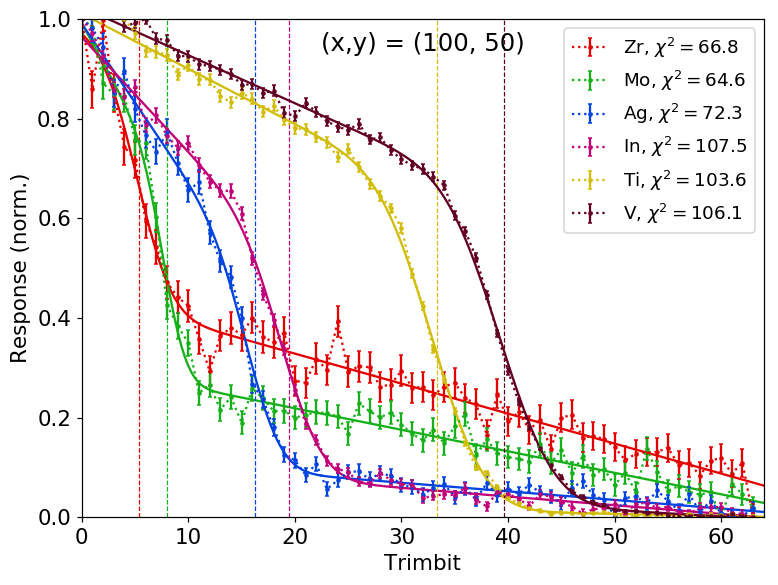

In [8]:
fig = plot.s_curves_plot(p3_det, 100, 50)

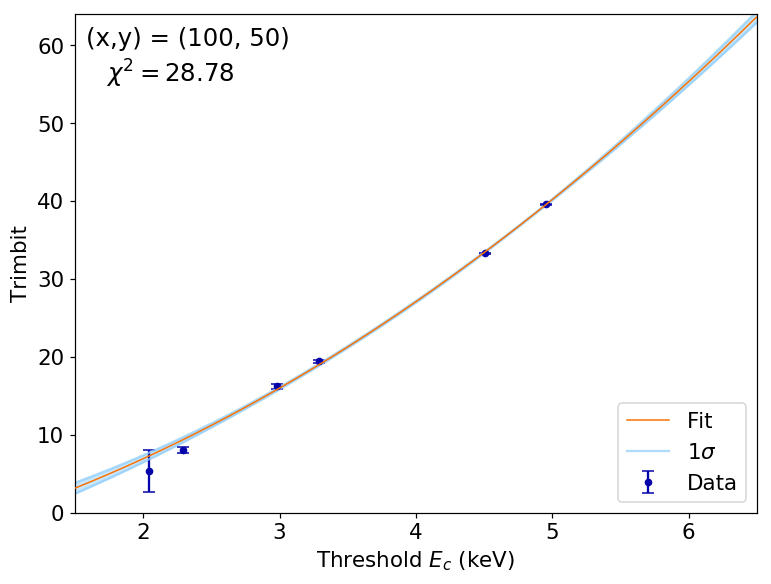

In [9]:
fig = plot.trimscan_curve(p3_det, 100, 50, xlim=[1.5, 6.5])

/home/pdvanmeter/lib/python/mesxr/calibration/plots.py:149: RuntimeWarning: invalid value encountered in greater
  rem_indices = np.where(chi2_set > cutoff)[0]
/home/pdvanmeter/miniconda2/envs/plasma/lib/python2.7/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/pdvanmeter/miniconda2/envs/plasma/lib/python2.7/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


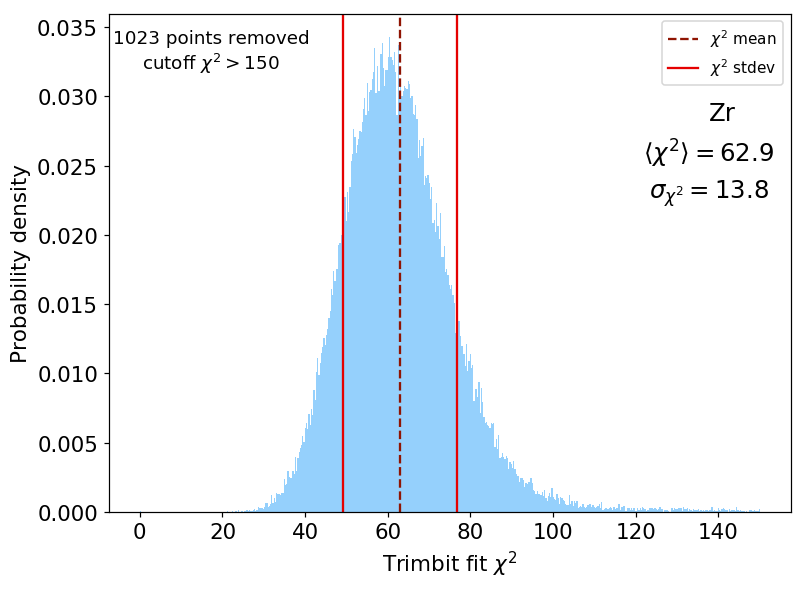

In [10]:
fig = plot.trimscan_chi2_plot(p3_det, 'Zr', range(16), chi_range=(0,150), cutoff=150, plot_stdev=True)

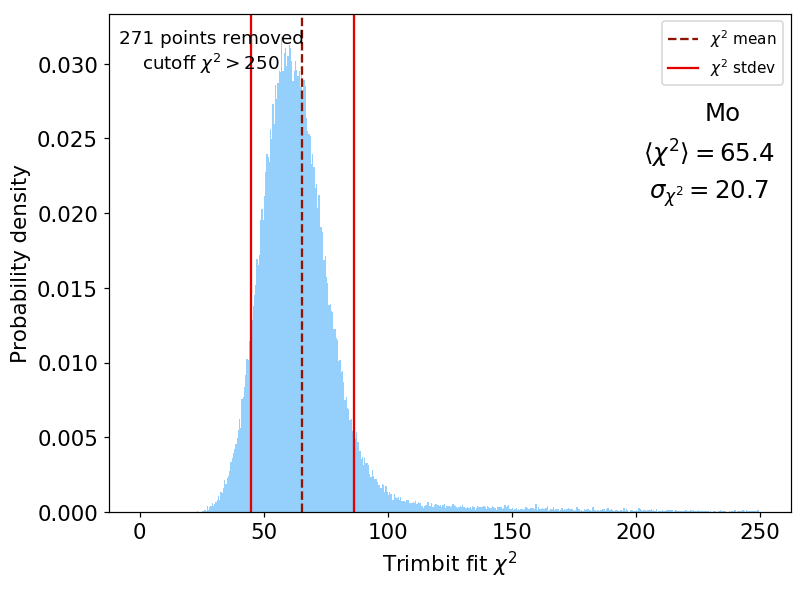

In [11]:
fig = plot.trimscan_chi2_plot(p3_det, 'Mo', range(16), chi_range=(0,250), cutoff=250, plot_stdev=True)

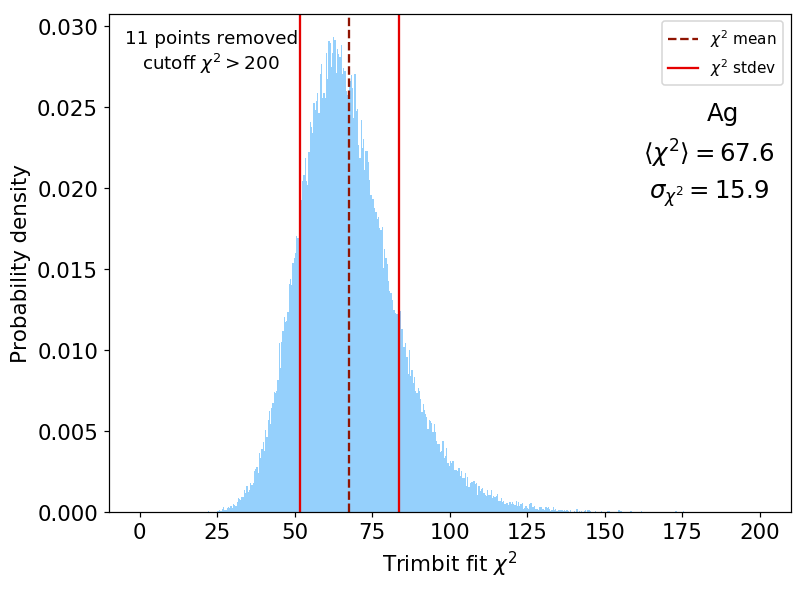

In [12]:
fig = plot.trimscan_chi2_plot(p3_det, 'Ag', range(16), chi_range=(0,200), cutoff=200, plot_stdev=True)

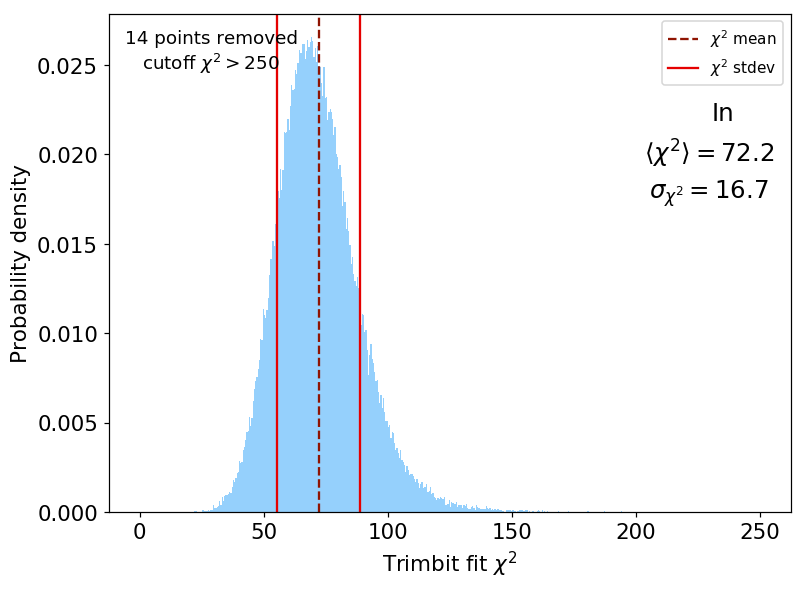

In [13]:
fig = plot.trimscan_chi2_plot(p3_det, 'In', range(16), chi_range=(0,250), cutoff=250, plot_stdev=True)

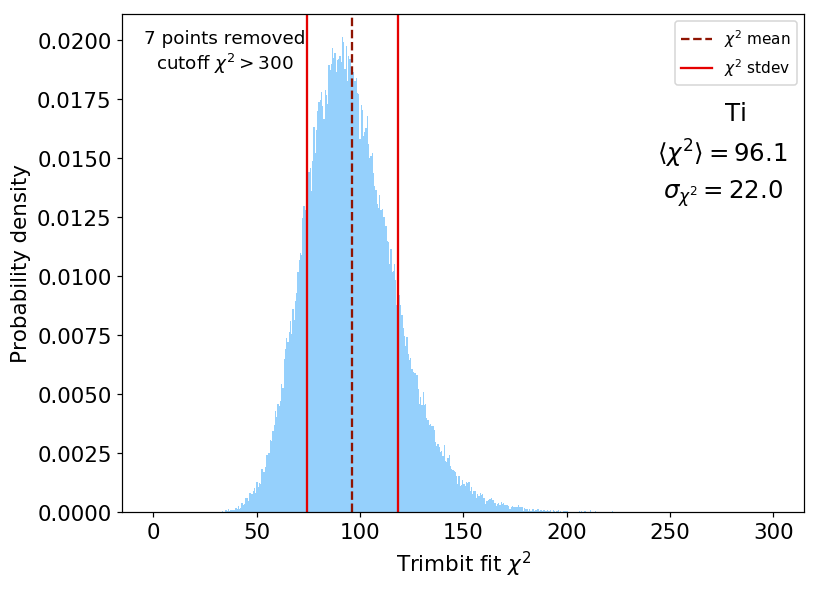

In [14]:
fig = plot.trimscan_chi2_plot(p3_det, 'Ti', range(16), chi_range=(0,300), cutoff=300, plot_stdev=True)

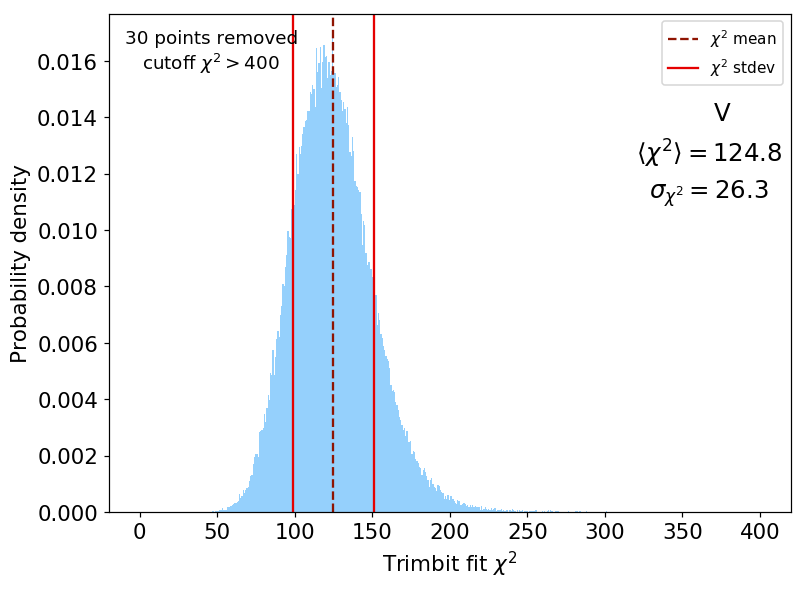

In [15]:
fig = plot.trimscan_chi2_plot(p3_det, 'V', range(16), chi_range=(0,400), cutoff=400, plot_stdev=True)

/home/pdvanmeter/lib/python/mesxr/calibration/plots.py:206: RuntimeWarning: invalid value encountered in greater
  rem_indices = np.where(chi2_set > cutoff)[0]


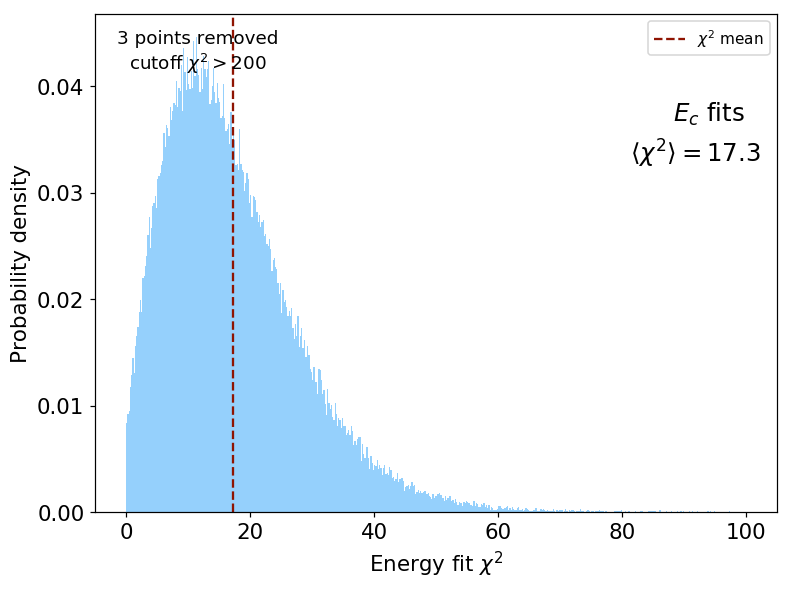

In [16]:
fig = plot.energy_chi2_plot(p3_det, range(16), chi_range=(0, 100), cutoff=200, plot_stdev=False)

## 2 - Corner Plots

Next, we want to look at corner plots for the distributions of the parameters in the fit. As a reminder, the trimscan data is fit to the following equation:

$N(\hat{t}) = \frac{1}{2} \bigg[erf(-\frac{\hat{t} - a_0}{\sqrt{2} a_1}) + 1\bigg] \cdot \big(a_2 + a_3 (\hat{t} - a_0)\big) + a_4 + a_5 (\hat{t} - a_0)$



In [17]:
reload(plot)

<module 'mesxr.calibration.plots' from '/home/pdvanmeter/lib/python/mesxr/calibration/plots.pyc'>

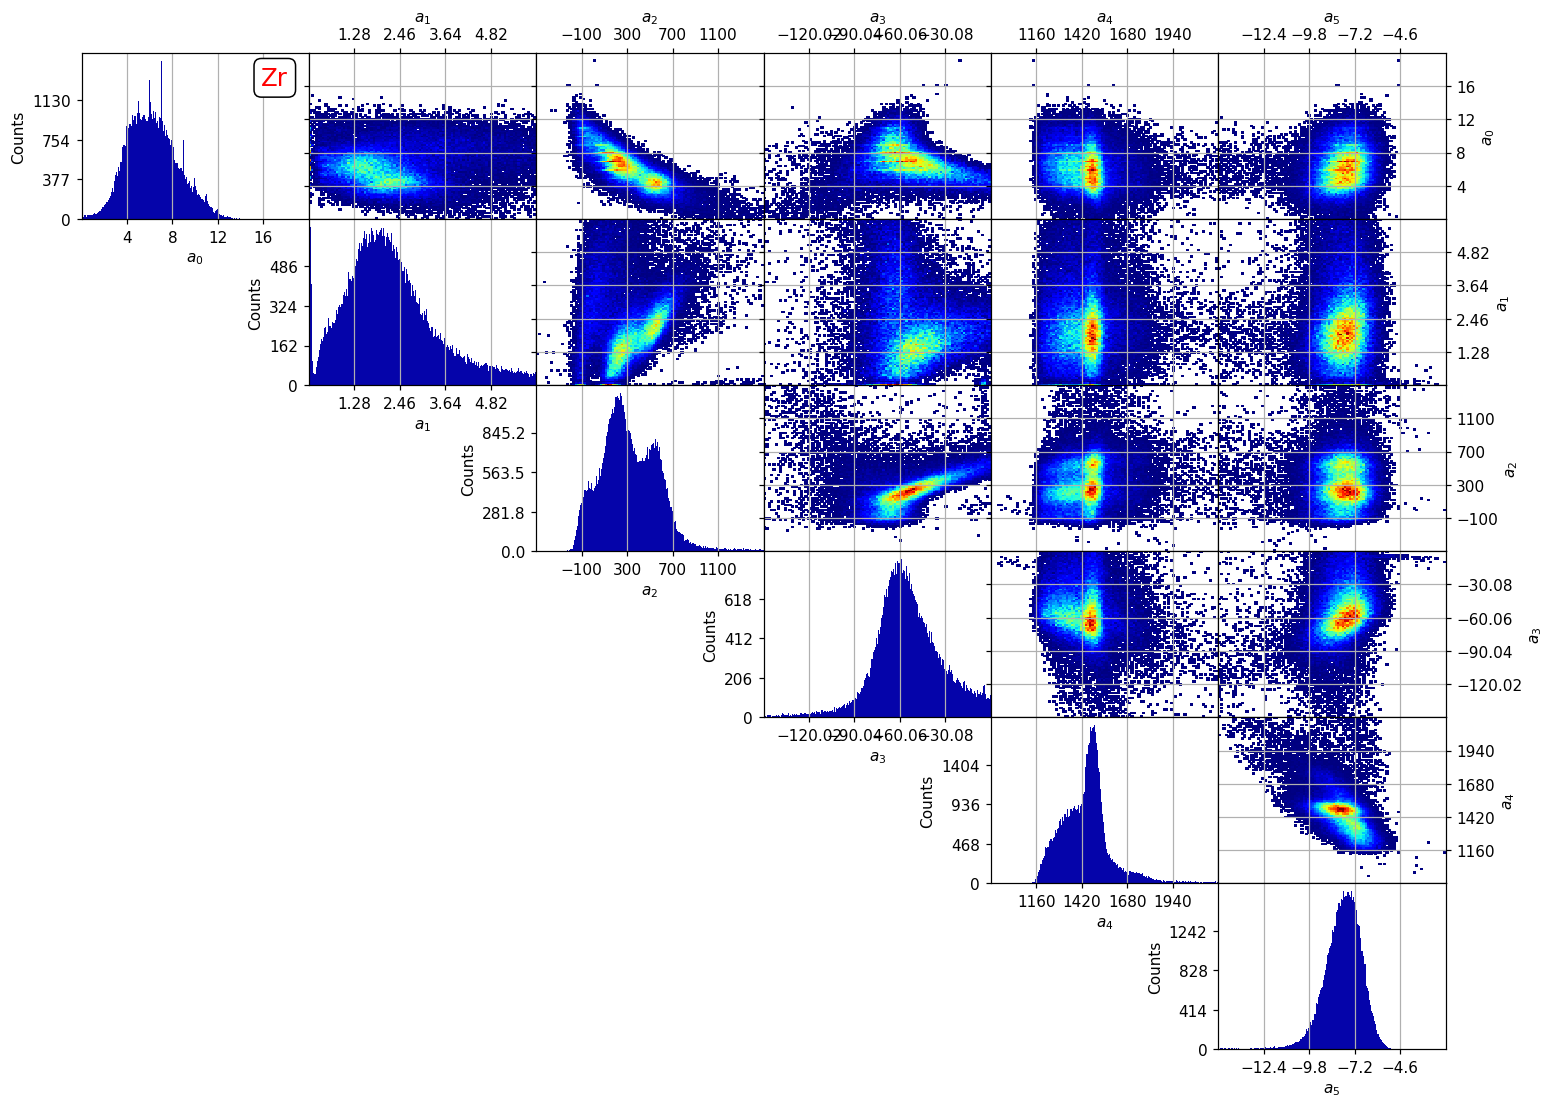

In [18]:
#           a0         a1           a2            a3           a4           a5
ranges = [[0, 20], [0.1, 6.0], [-500, 1500], [-150, -0.1], [900, 2200], [-15, -2]]
element = 'Zr'

fig = plot.trimscan_corner_plot(p3_det, element, ranges)

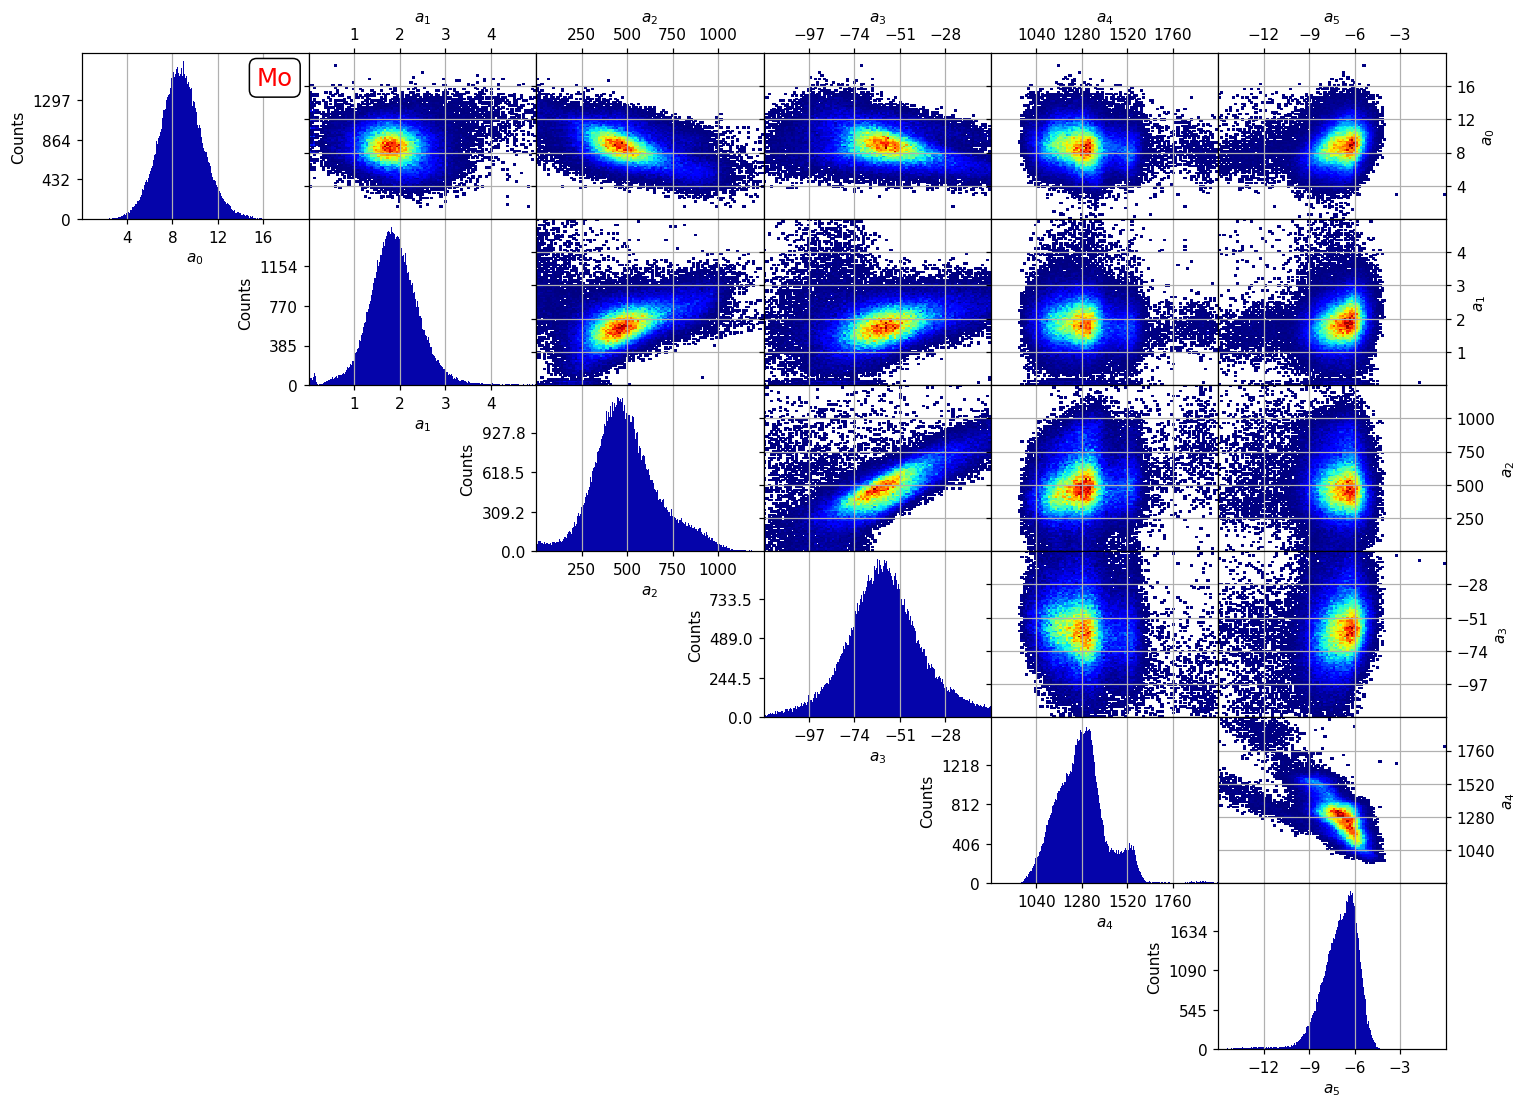

In [19]:
#           a0         a1           a2            a3           a4           a5
ranges = [[0, 20], [0., 5.0], [0, 1250], [-120, -5.0], [800, 2000], [-15, 0]]
element = 'Mo'

fig = plot.trimscan_corner_plot(p3_det, element, ranges)

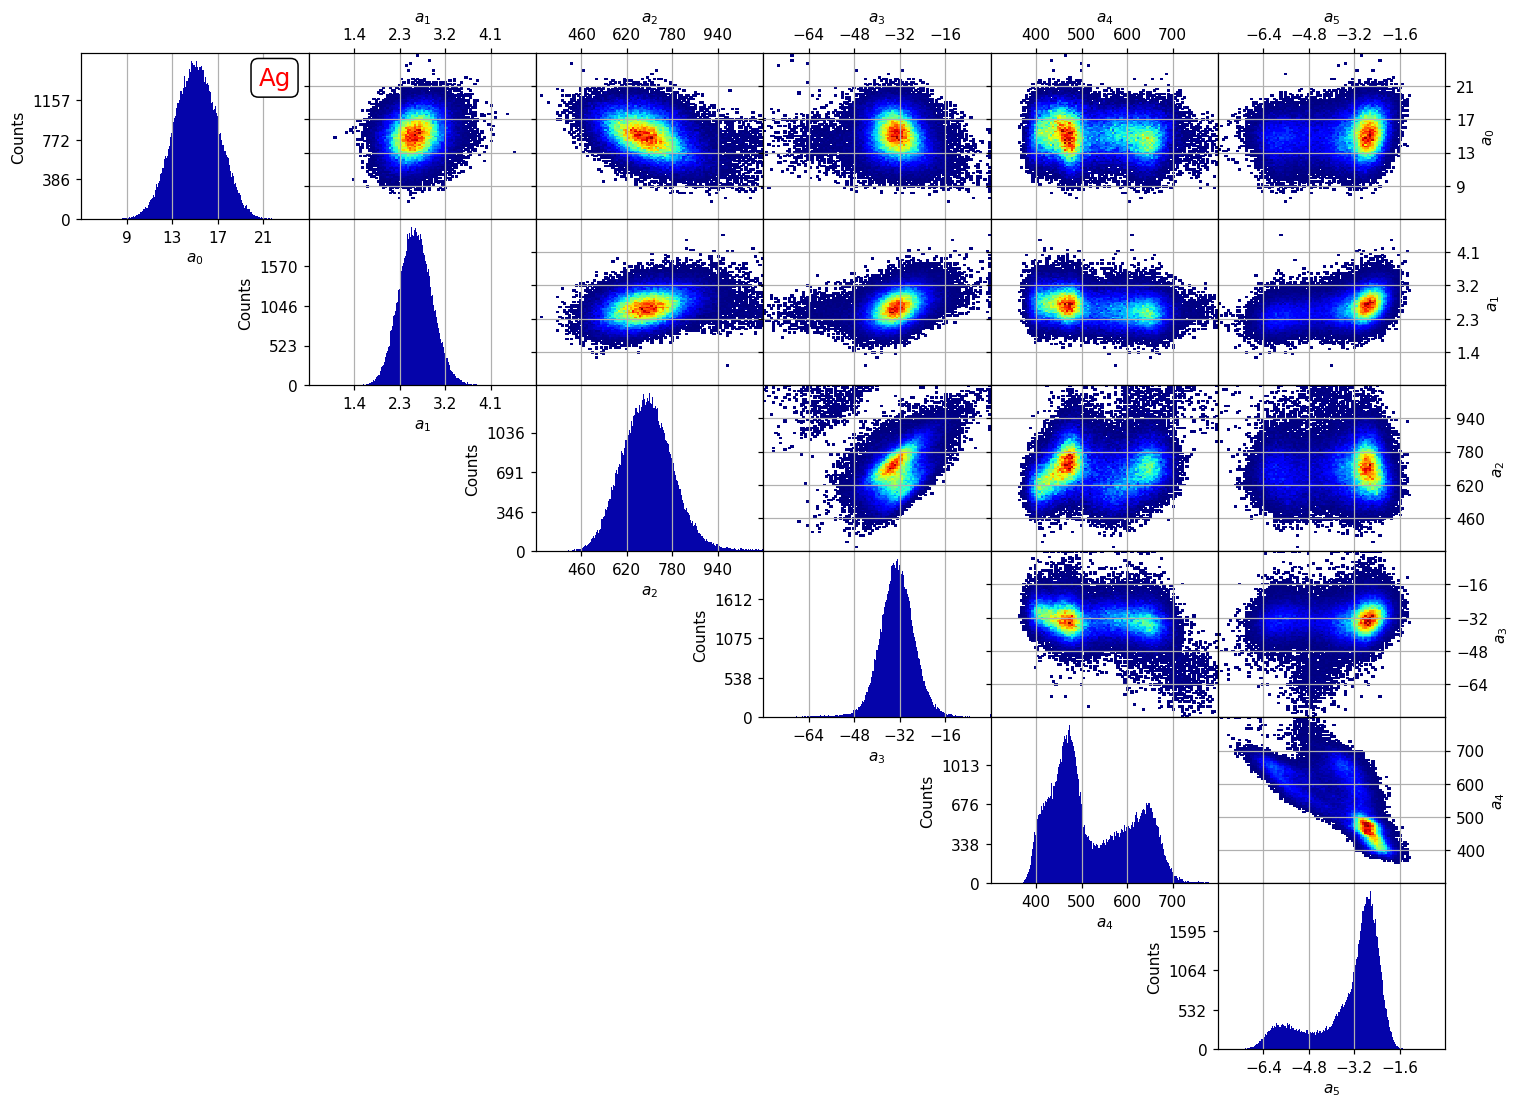

In [20]:
#           a0         a1           a2            a3           a4           a5
ranges = [[5, 25], [0.5, 5.0], [300, 1100], [-80, 0], [300, 800], [-8, 0]]
element = 'Ag'

fig = plot.trimscan_corner_plot(p3_det, element, ranges)

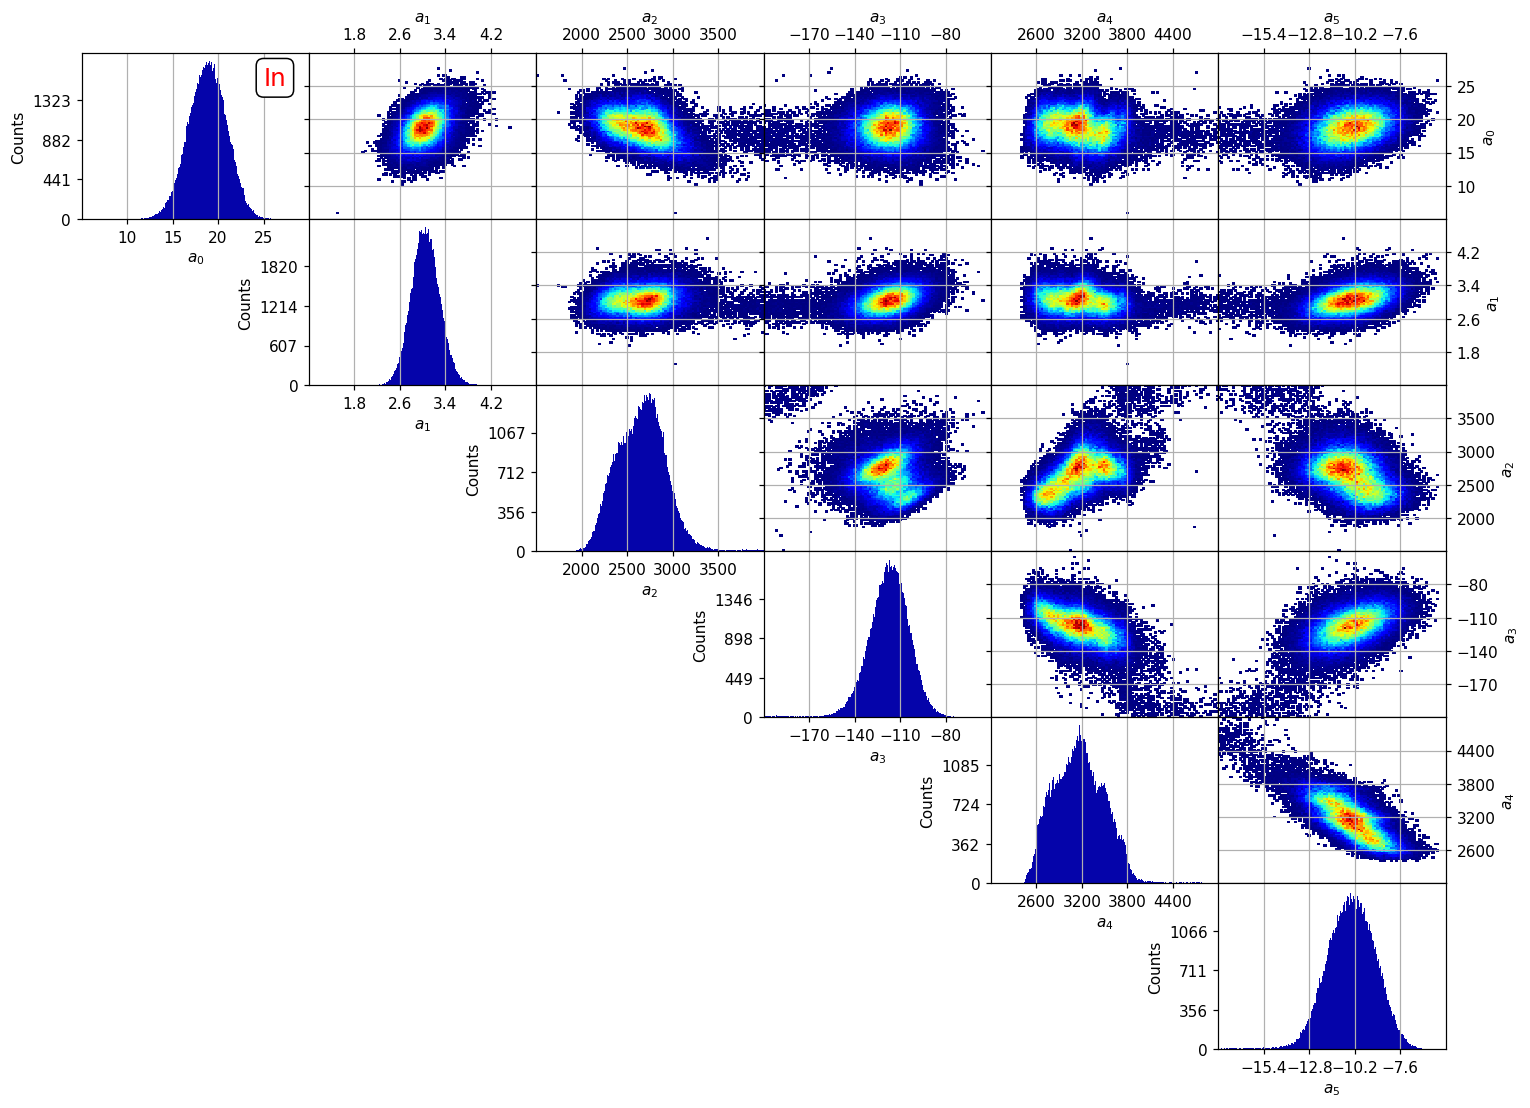

In [21]:
#           a0         a1           a2            a3           a4           a5
ranges = [[5, 30], [1.0, 5.0], [1500, 4000], [-200, -50], [2000, 5000], [-18, -5]]
element = 'In'

fig = plot.trimscan_corner_plot(p3_det, element, ranges)

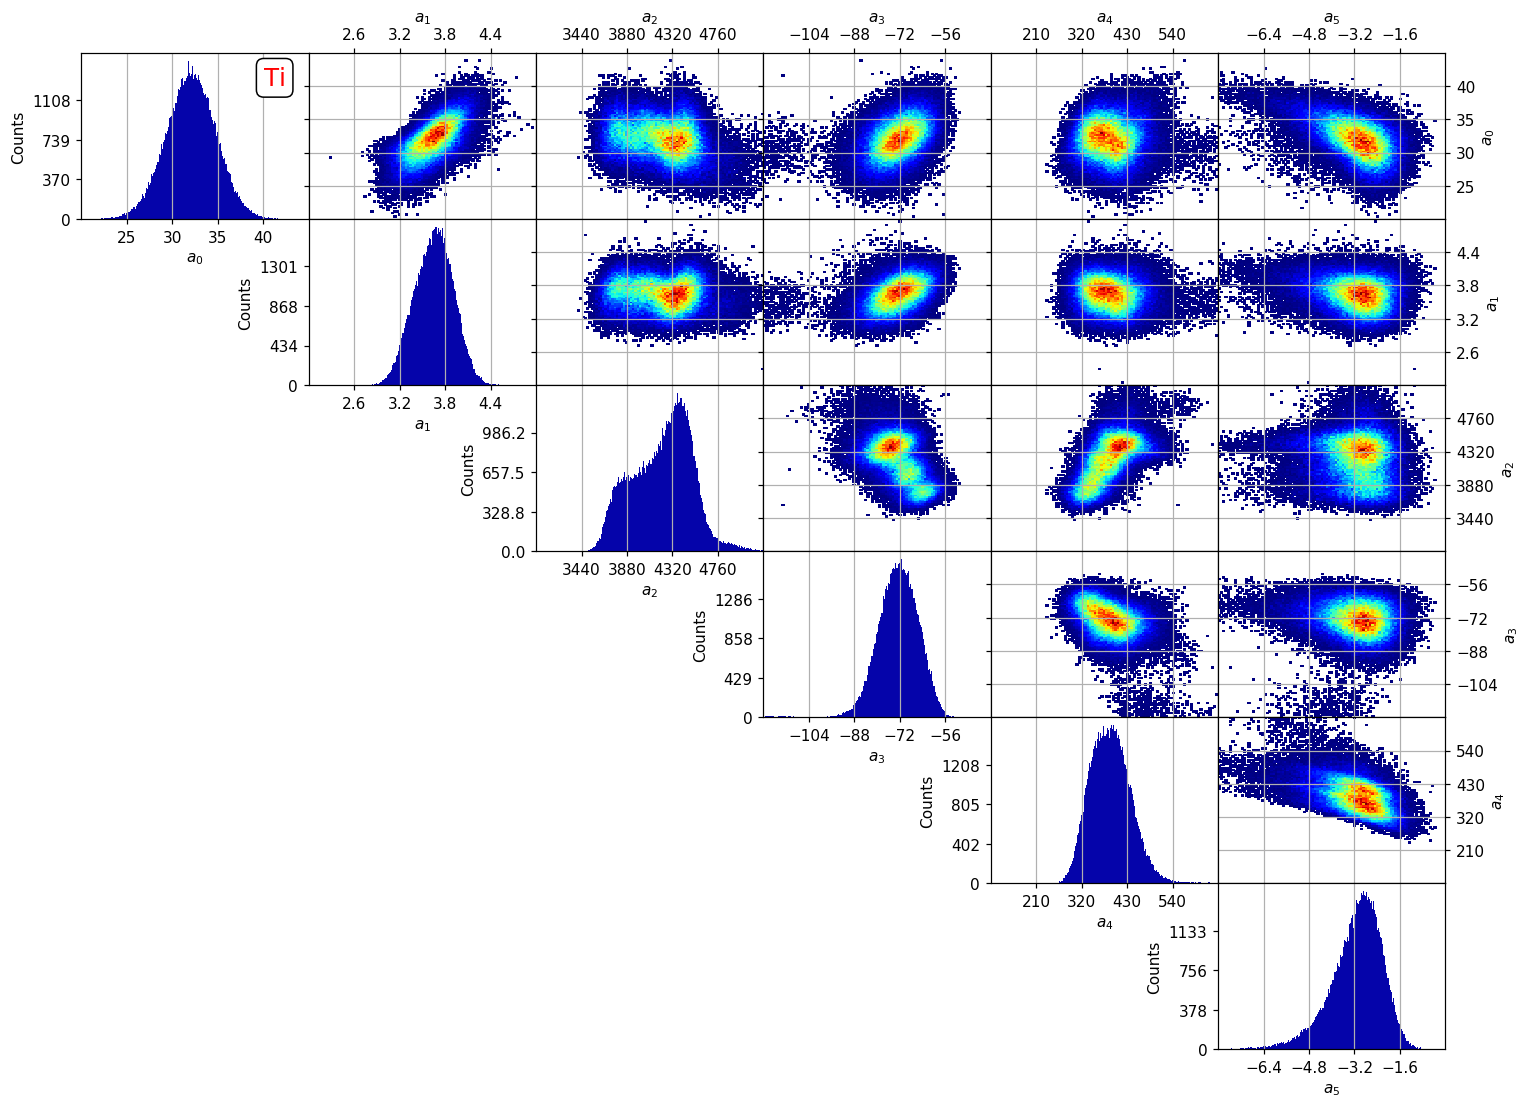

In [22]:
#           a0         a1           a2            a3           a4           a5
ranges = [[20, 45], [2.0, 5.0], [3000, 5200], [-120, -40], [100, 650], [-8, 0]]
element = 'Ti'

fig = plot.trimscan_corner_plot(p3_det, element, ranges)

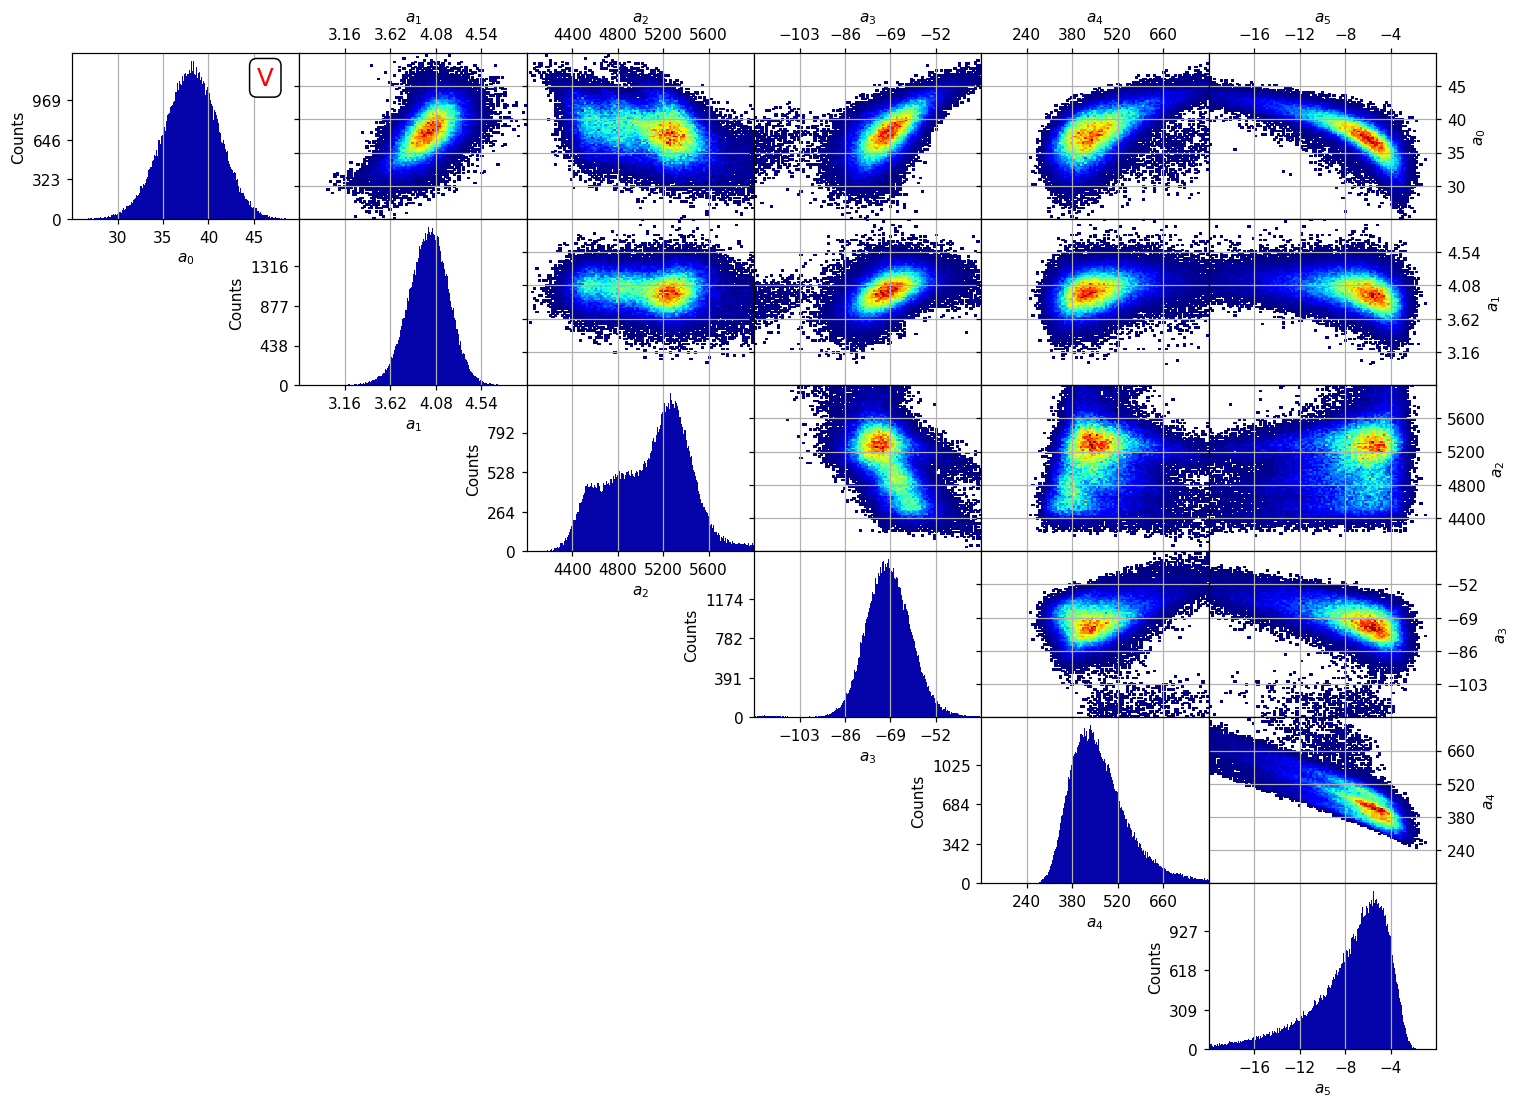

In [23]:
#           a0         a1           a2            a3           a4           a5
ranges = [[25, 50], [2.7, 5.0], [4000, 6000], [-120, -35], [100, 800], [-20, 0]]
element = 'V'

fig = plot.trimscan_corner_plot(p3_det, element, ranges)

Now, let's look at the corner plot for the quadratic energy fit, given by:

$\hat{t}(E_c) = c_0 E_c^2 + c_1 E_c + c_2$

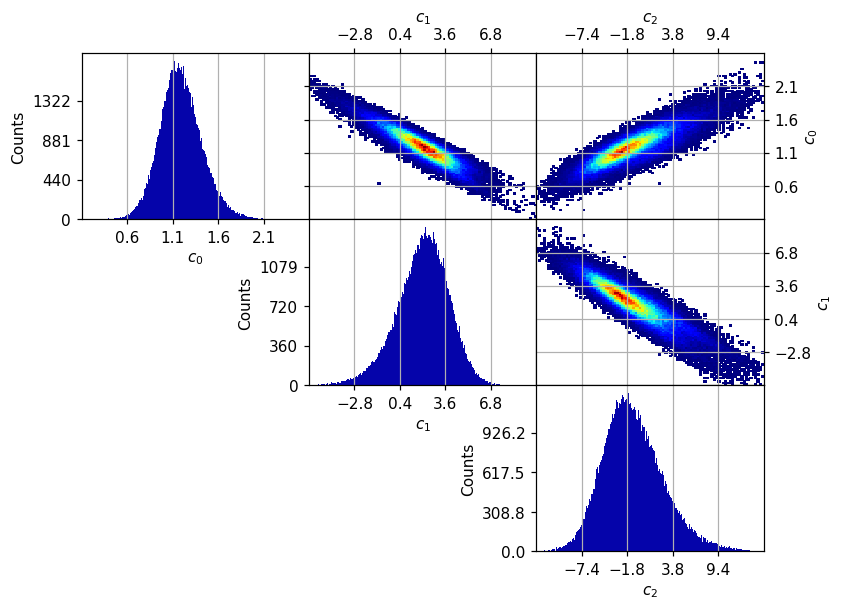

In [24]:
#            c0      c1         c2
ranges = [[0.1, 2.6], [-6, 10], [-13, 15]]

fig = plot.energy_corner_plot(p3_det, ranges)

## 3 - Uniform threshold analysis

The goal of this section is to set the detector to a series of uniform thresholds in order to investigate variations across the detector.

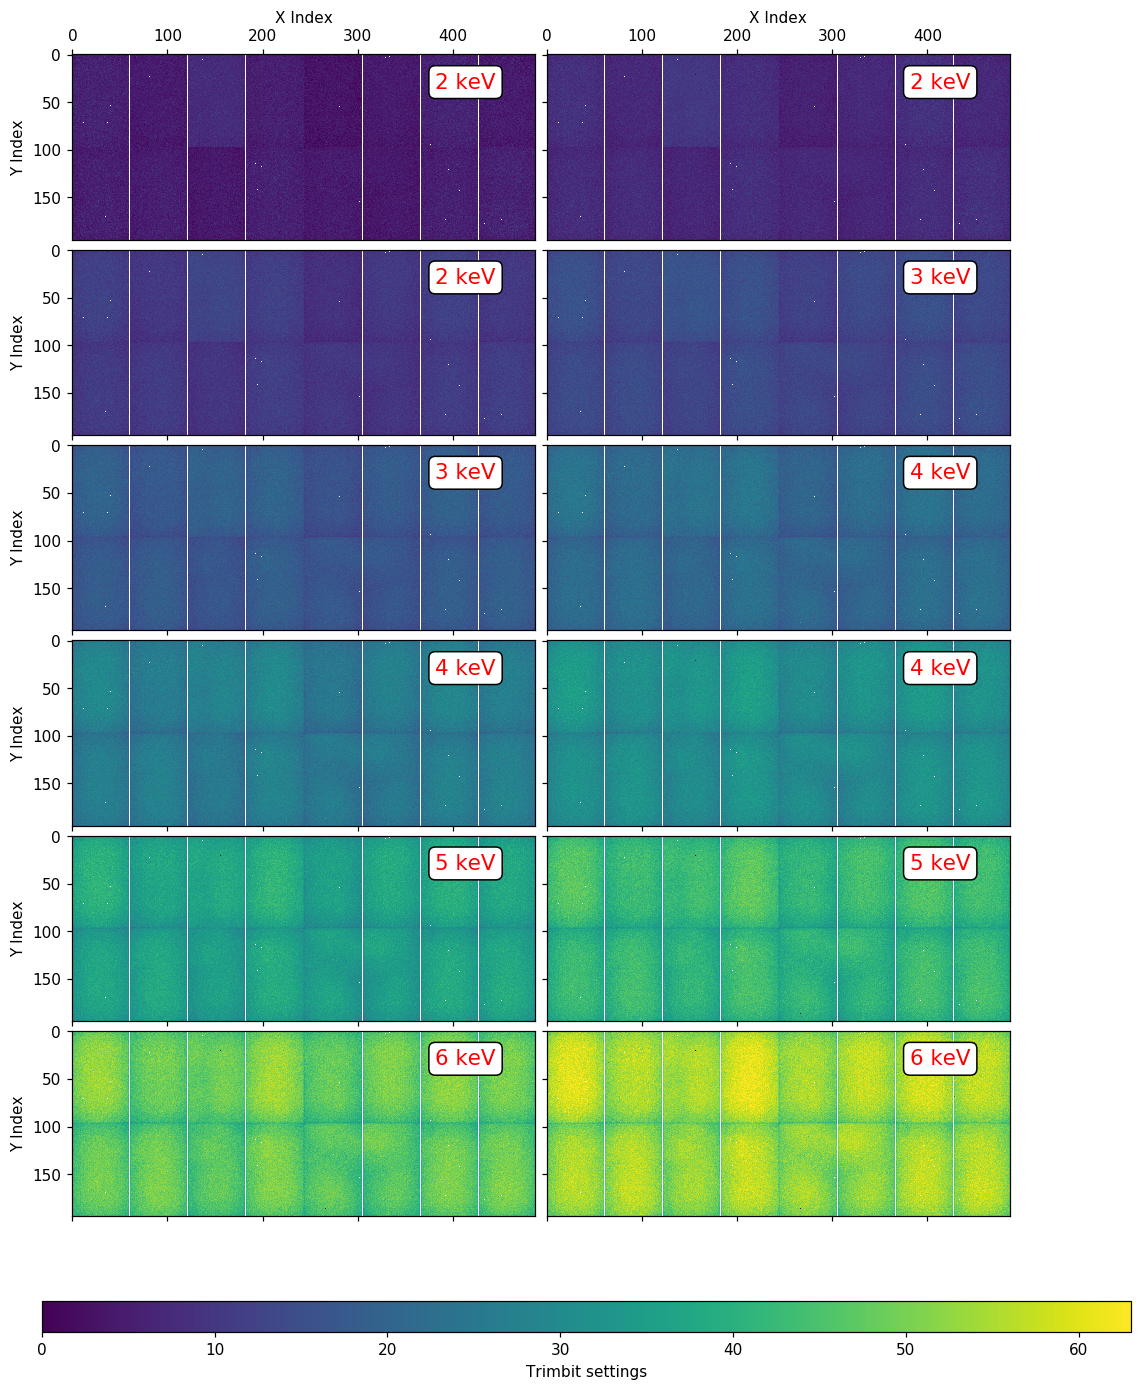

In [25]:
threshold_set = np.arange(1.6, 6.1, .4)
fig = plot.uniform_treshold_trimbit_maps(p3_det, threshold_set, figsize=(11,14))

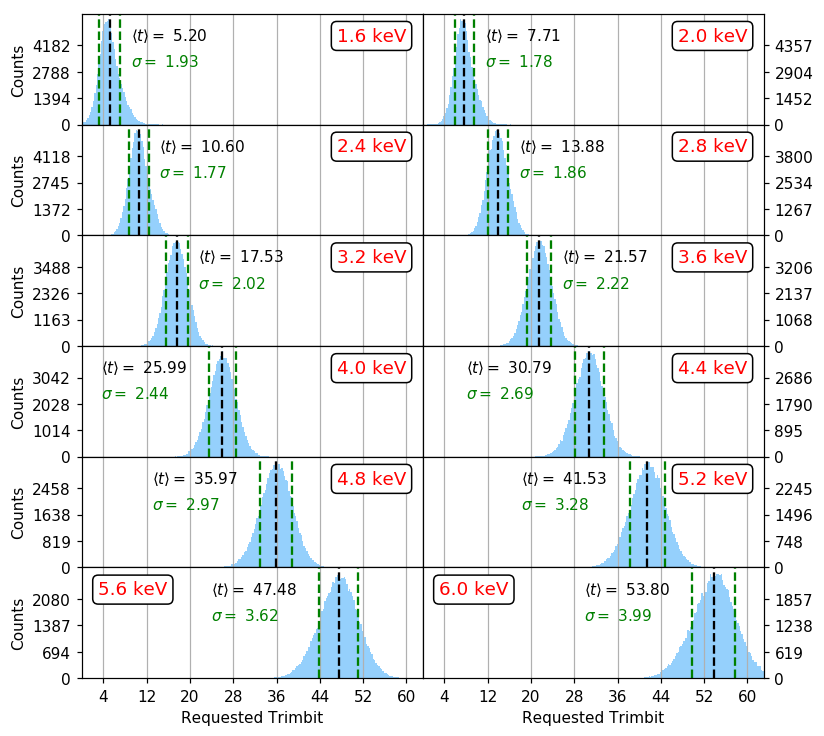

In [26]:
fig = plot.uniform_treshold_trimbit_distributions(p3_det, threshold_set, figsize=(8,8))

The next plot investigates the impact of trimbit rounding on the ability to set a specific threshold across the detector. This can be thought of as a sort of "resolution" to which one can meaningfully set a specific threshold, on average. In practice, this sets a limit to how closely spaced thresholds should be set to one another.

/home/pdvanmeter/lib/python/mesxr/calibration/trimscan.py:150: RuntimeWarning: invalid value encountered in sqrt
  return (-c1 + np.sqrt(c1**2 - 4*c0*(c2 - trimbit))) / (2*c0)


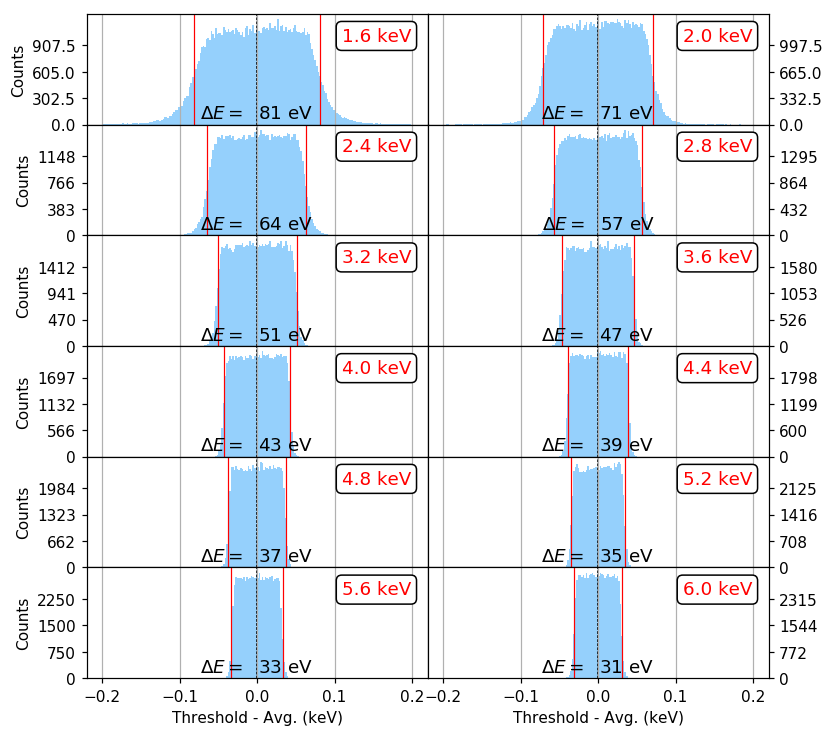

In [27]:
fig, delta_E = plot.uniform_treshold_delta_E(p3_det, threshold_set, figsize=(8,8), xrange=[-.2,.2])

In [28]:
from scipy.interpolate import spline

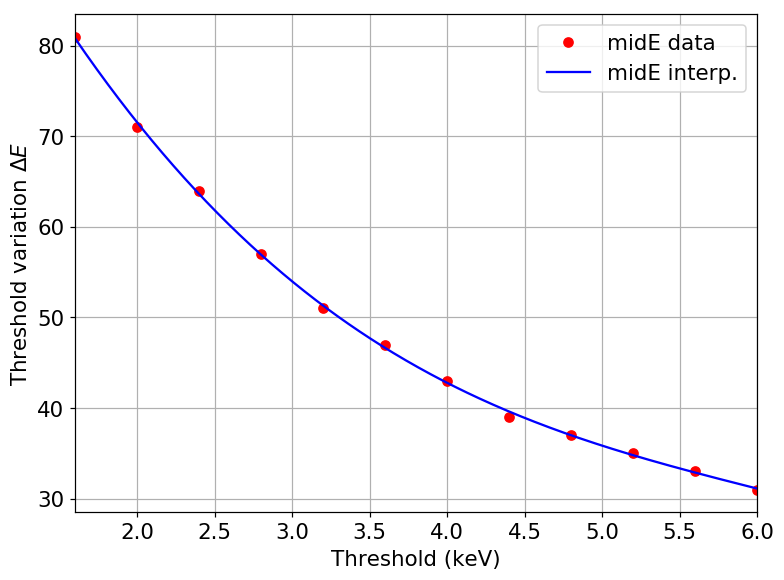

In [29]:
fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1, 1, 1)
plt.tick_params(labelsize=14)

ax.plot(threshold_set, delta_E, 'o', color='red', label='midE data')

# Smoothed spline fit to illustrate mapping
thresh = np.linspace(np.amin(threshold_set), np.amax(threshold_set), 500)
dE = sp.interpolate.UnivariateSpline(threshold_set, delta_E, k=3)
ax.plot(thresh, dE(thresh), color='blue', label='midE interp.')
ax.set_xlim([np.amin(threshold_set), np.amax(threshold_set)])

# Plot labels
ax.set_xlabel('Threshold (keV)', fontsize=14)
ax.set_ylabel(r'Threshold variation $\Delta E$', fontsize=14)
ax.legend(loc='upper right', fontsize=14)
ax.grid()

## 4 - Comparison to original calibration

In [30]:
import tifffile as tif

Text(0.5,1,'Trimbit settings old vs. new ($E_c = 3.0$ keV)')

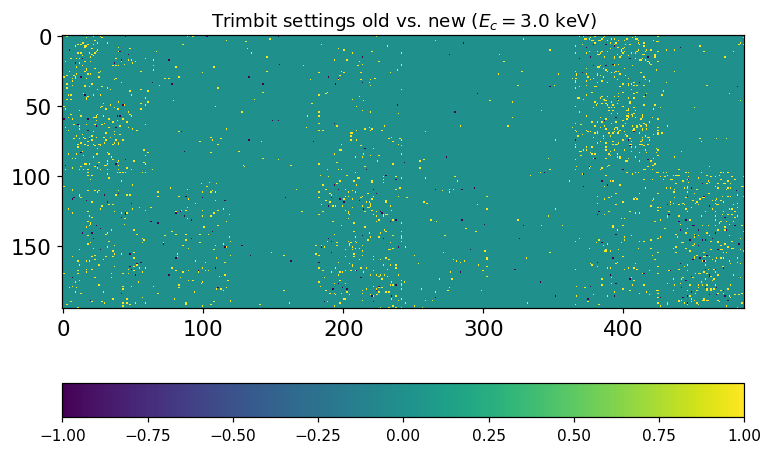

In [31]:
# A basic threshold map for comparison
Ec = 3.0
threshold_map = Ec*np.ones(p3_det.global_pixel_dims)

# Now convert this to trimbit values using the new method
trimbits_new = p3_det.get_trimbit_map(threshold_map)

# Also load old results for the same threshold from file
old_path = '/home/pdvanmeter/data/meSXR/MST/configuration/MST_2_to_7_keV_vacuum/single_energy_{0:d}p{1:d}'.format(int(Ec), int(Ec*10 - int(Ec)*10))
fname = 'single_energy_{0:d}p{1:d}_trimbit.tif'.format(int(Ec), int(Ec*10 - int(Ec)*10))
trimbits_old = tif.imread(os.path.join(old_path, fname)).T

# Plot the results
fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1, 1, 1)
plt.tick_params(labelsize=14)

cax = ax.imshow((trimbits_old - trimbits_new).T, vmin=-1, vmax=1)
fig.colorbar(cax, orientation='horizontal')
ax.set_title(r'Trimbit settings old vs. new ($E_c = {0:.1f}$ keV)'.format(Ec))

In [32]:
bins, counts = np.unique(trimbits_old - trimbits_new, return_counts=True)
print(bins)
print(counts)

[-27 -25 -24  -5  -4  -2  -1   0   1   2   5   6  15  16  18  19  20  21]
[    1     1     2     1     1     1   244 93038  1611    47     2     1
     1     1     4     6     1     2]


Text(0.5,1,'Trimbit settings old vs. new ($E_c = 1.8$ keV)')

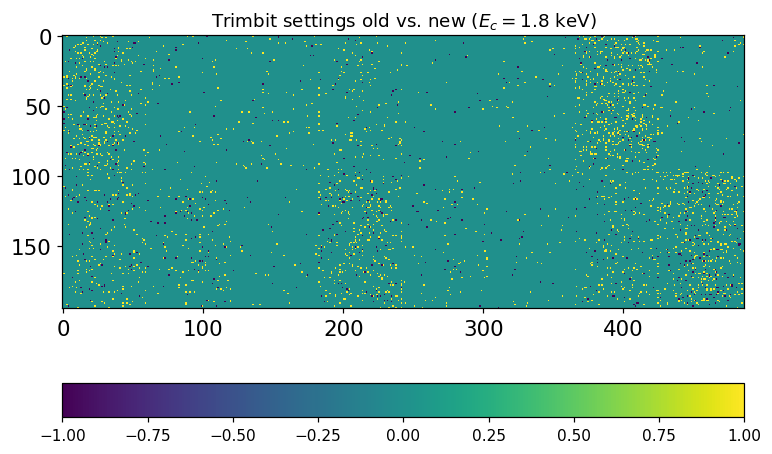

In [33]:
# A basic threshold map for comparison
Ec = 1.8
threshold_map = Ec*np.ones(p3_det.global_pixel_dims)

# Now convert this to trimbit values using the new method
trimbits_new = p3_det.get_trimbit_map(threshold_map)

# Also load old results for the same threshold from file
old_path = '/home/pdvanmeter/data/meSXR/MST/configuration/MST_2_to_7_keV_vacuum/single_energy_{0:d}p{1:d}'.format(int(Ec), int(Ec*10 - int(Ec)*10))
fname = 'single_energy_{0:d}p{1:d}_trimbit.tif'.format(int(Ec), int(Ec*10 - int(Ec)*10))
trimbits_old = tif.imread(os.path.join(old_path, fname)).T

# Plot the results
fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1, 1, 1)
plt.tick_params(labelsize=14)

cax = ax.imshow((trimbits_old - trimbits_new).T, vmin=-1, vmax=1)
fig.colorbar(cax, orientation='horizontal')
ax.set_title(r'Trimbit settings old vs. new ($E_c = {0:.1f}$ keV)'.format(Ec))

In [34]:
np.unique(trimbits_old - trimbits_new, return_counts=True)

(array([-21,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,
          7,   8,   9,  10,  11,  24,  26,  29]),
 array([    2,     4,    13,    67,   178,   470, 91804,  1012,   853,
          444,    74,    18,     6,     2,     4,     5,     4,     2,
            1,     1,     1]))

The new version of the lowE calibration actually turns out to be more consistent with the prior calibration than the midE did. This is interesting because response problems were more readily apparent in the midE data. Hopefully this serves as a correction to that discrepency.

# 5 - Bad pixel investigation

I also want to take a look at the "bad pixels." Does this calibration adequately catch them? It should print out a file containing these pixels so that the operation/data processing code can identify them without loading in the full calibration.

In [35]:
num_bad = len(p3_det.bad_pixels)
print('Found {0:d} bad fits.'.format(num_bad))

# Pick a random coordinate
rand_coord = p3_det.bad_pixels[np.random.randint(0, num_bad)]
print('Random selection: ' + str(rand_coord) + '.')

Found 22 bad fits.
Random selection: (37, 71).


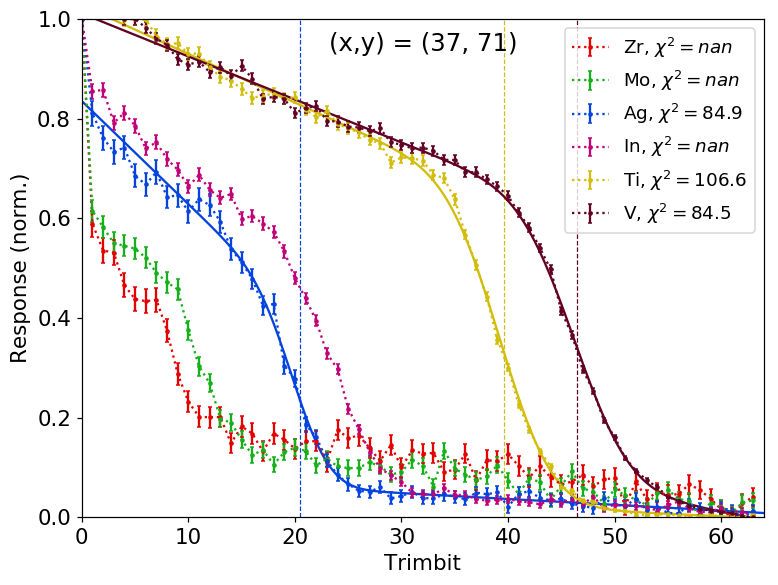

In [36]:
fig = plot.s_curves_plot(p3_det, *rand_coord)

In [37]:
print(p3_det.bad_pixels)

[(12, 71), (35, 170), (37, 71), (40, 53), (81, 23), (136, 5), (179, 36), (192, 114), (194, 142), (198, 117), (231, 140), (280, 55), (301, 154), (329, 3), (333, 2), (376, 94), (392, 173), (395, 121), (406, 143), (412, 127), (432, 177), (450, 173)]


This pixel is clearly bad, so removing it is the correct choice. Once again, pixel detection seems to do pretty well. From my previous work I expected to find: (333, 2), (280, 55), (12, 71), (376, 94), and (198, 117). Most of these were not selected. So they will need to be added in manualy. I have plotted the suspect pixels below to verify their problematic responses.

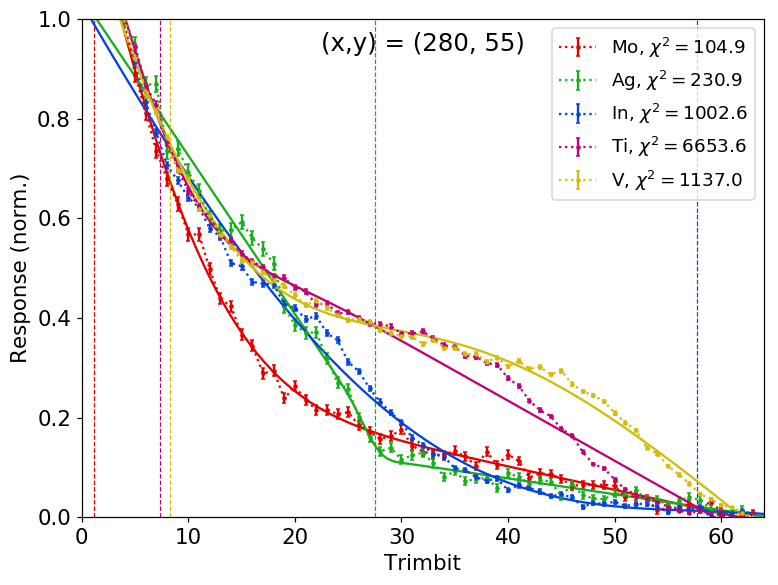

In [38]:
fig = plot.s_curves_plot(p3_det, 280, 55)

/home/pdvanmeter/lib/python/mesxr/calibration/plots.py:49: RuntimeWarning: invalid value encountered in divide
  data_scaled = data_adj / scale_fact
/home/pdvanmeter/lib/python/mesxr/calibration/plots.py:50: RuntimeWarning: divide by zero encountered in divide
  sigma_scaled = np.sqrt(trimscan_data[index]) / scale_fact
/home/pdvanmeter/lib/python/mesxr/calibration/plots.py:59: RuntimeWarning: divide by zero encountered in divide
  model_scale = model_adj / scale_fact


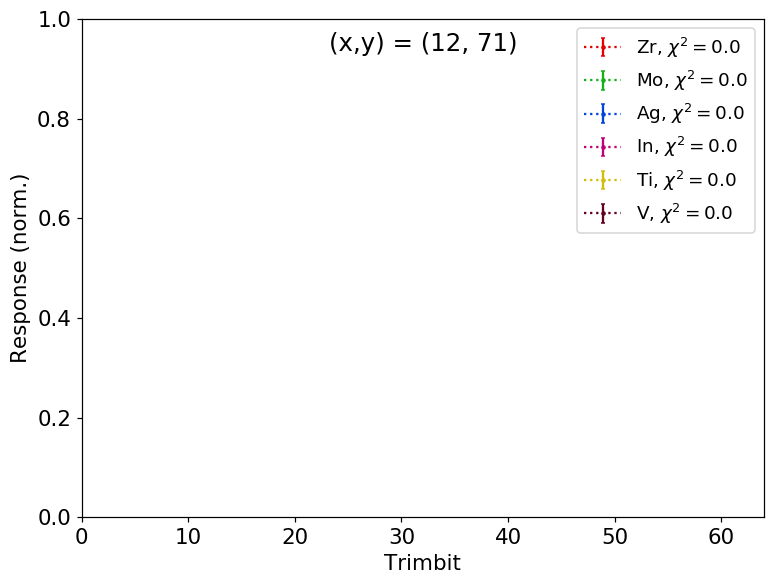

In [39]:
fig = plot.s_curves_plot(p3_det, 12, 71)

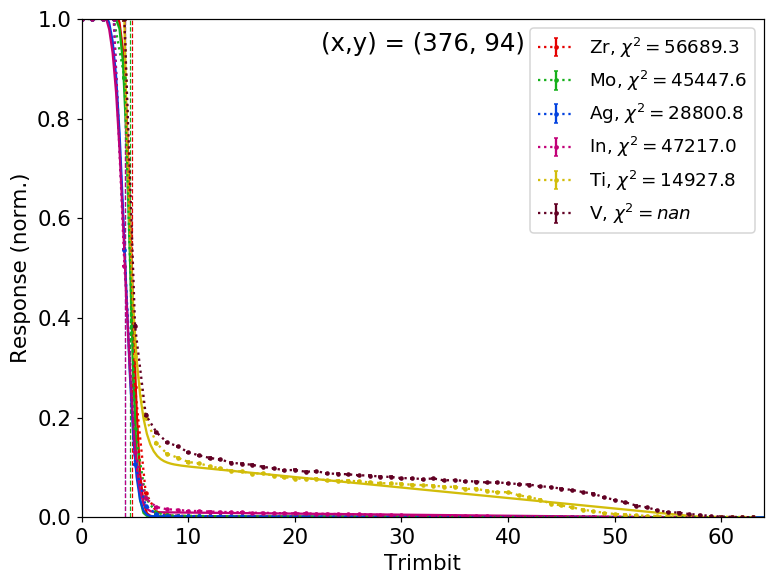

In [40]:
fig = plot.s_curves_plot(p3_det, 376, 94)

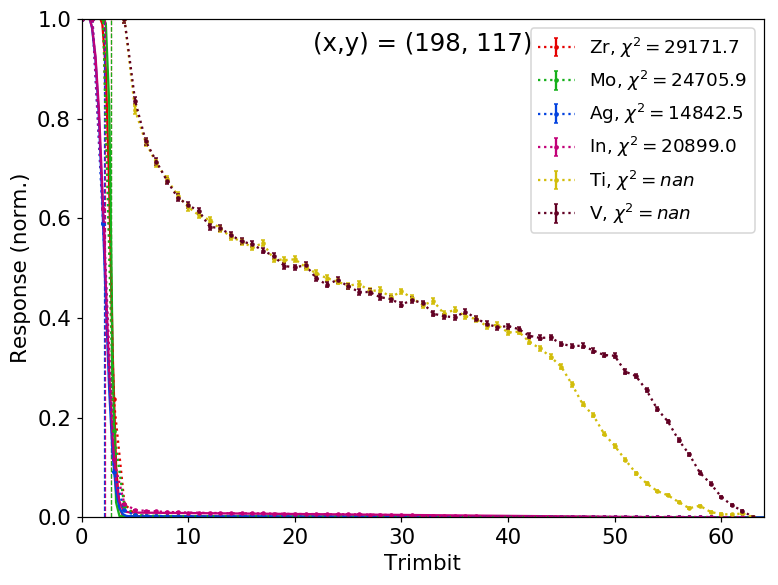

In [41]:
fig = plot.s_curves_plot(p3_det, 198, 117)

In [42]:
def chi2_map(elem, vmax=200):
    # Generate the data
    chi2_map = np.zeros(p3_det.global_pixel_dims)

    for x in range(chi2_map.shape[0]):
        for y in range(chi2_map.shape[1]):
            if elem in p3_det.pixels[x,y].elements:
                elem_index = p3_det.pixels[x,y].elements.index(elem)
                chi2_map[x,y] = p3_det.pixels[x,y].trimfit_chi2[elem_index]
    
    # Make the plot
    fig = plt.figure(1, figsize=(8,6), dpi=110)
    ax = fig.add_subplot(1, 1, 1)
    plt.tick_params(labelsize=14)

    image = ax.imshow(chi2_map.T, vmin=0, vmax=vmax)
    fig.colorbar(image, orientation='horizontal', label=r'{0:} $\chi^2$'.format(elem))
    
    return fig

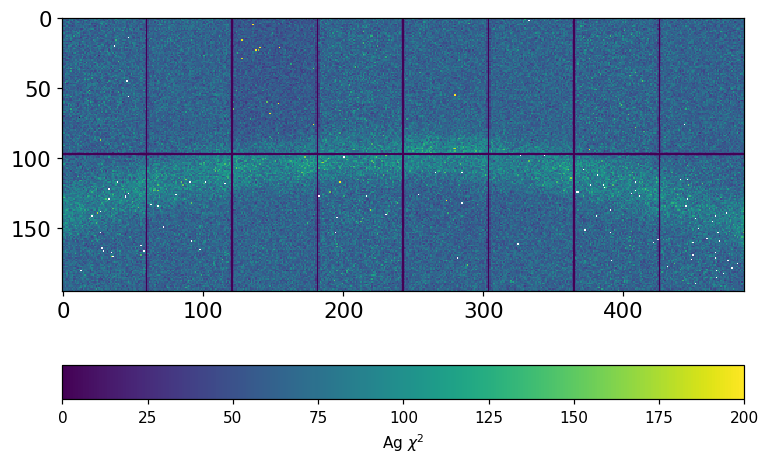

In [43]:
fig = chi2_map('Ag', vmax=200)

In order to determine which pixels to modify, a "ratio test" was implemented. The work which led me to this decision is shown below.

In [44]:
def ratio_test(det, element, high=0, low=1):
    ratio_map = np.zeros(det.global_pixel_dims)
    
    for x in range(ratio_map.shape[0]):
        for y in range(ratio_map.shape[1]):
            if element in det.pixels[x,y].elements:
                elem_index = det.pixels[x,y].elements.index(element
                                                           )
                if high in det.pixels[x,y].trimbits[elem_index] and low in det.pixels[x,y].trimbits[elem_index]:
                    index_h = np.where(det.pixels[x,y].trimbits[elem_index] == high)[0][0]
                    index_l = np.where(det.pixels[x,y].trimbits[elem_index] == low)[0][0]
                    ratio_map[x,y] = det.pixels[x,y].data[elem_index][index_h] / (det.pixels[x,y].data[elem_index][index_l] + 0.001)
                    
                else:
                    ratio_map[x,y] = np.nan
            else:
                ratio_map[x,y] = np.nan
                    
    return ratio_map

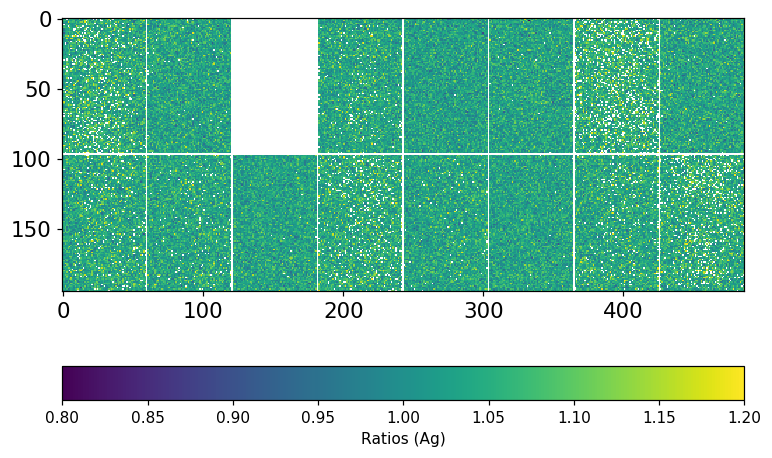

In [45]:
element = 'Ag'

ratios = ratio_test(p3_det, element)

fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1, 1, 1)
plt.tick_params(labelsize=14)

image = ax.imshow(ratios.T, vmin=.8, vmax=1.2)
fig.colorbar(image, orientation='horizontal', label='Ratios ({0:})'.format(element))

In [46]:
#cutoffs = [1.2, 1.4, 1.5, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 10.0]
cutoffs = [1.0, 1.05, 1.1, 1.15, 1.2]

for cutoff in cutoffs:
    count = 0

    for x in range(ratios.shape[0]):
        for y in range(ratios.shape[1]):
            if ratios[x,y] > cutoff:
                count += 1

    print('Found {0:d} pixels with R > {1:.1f}.'.format(count, cutoff))

Found 69535 pixels with R > 1.0.
Found 30881 pixels with R > 1.1.
Found 6472 pixels with R > 1.1.
Found 1226 pixels with R > 1.1.
Found 0 pixels with R > 1.2.


In [47]:
ratio_list = []

for x in range(ratios.shape[0]):
    for y in range(ratios.shape[1]):
        if not np.isnan(ratios[x,y]):
            ratio_list.append(ratios[x,y])
            
ratio_list = np.array(ratio_list)

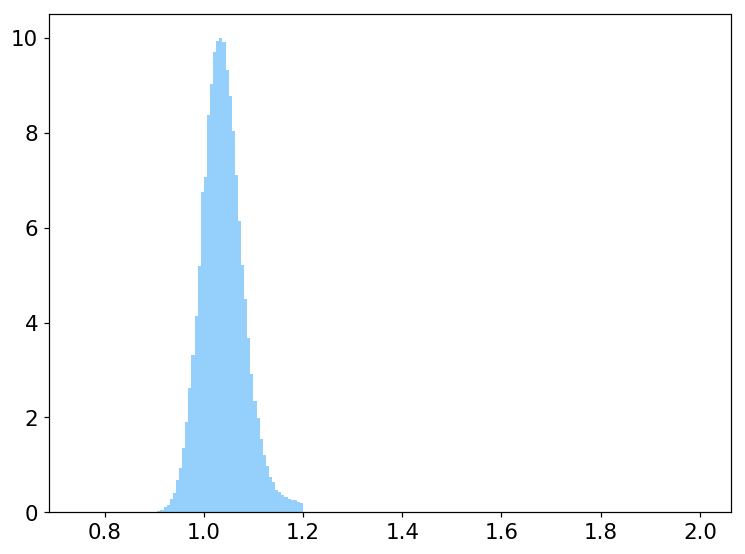

In [48]:
fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1,1,1)
plt.tick_params(labelsize=14)

#hist = ax.hist(ratio_list, bins=200, density=True, range=[0.75,1.75], color='xkcd:light blue')
hist = ax.hist(ratio_list, bins=200, density=True, range=[0.75, 2.0], color='xkcd:light blue')